# Making normalized distributions
- processes an `events[year][ch][sample]` object using `make_events_dict()` per defined region
- plots normalized distributions of a chosen sample for a chosen region

In [214]:
! ls outfiles/0-1_ele.parquet

0-1.pkl         0-1_ele.parquet


In [216]:
d = pd.read_parquet("outfiles/0-1_ele.parquet")
d

,fj_msoftdrop,lep_pt,lep_isolation,lep_misolation,lep_fj_dr,lep_met_mt,met_fj_dphi,met_pt,deta,mjj,...,weight_ele_trigger_electronUp,weight_ele_isolation_electronDown,weight_ele_L1PrefiringDown,weight_ele_btagSFbc_correlatedDown,weight_ele_reco_electronUp,weight_ele_btagSFbc_2017Up,weight_ele_trigger_electronDown,weight_ele_id_electronUp,weight_ele_btagSFbc_correlatedUp,weight_ele_isolation_electronUp
0,48.209747,151.115601,0.006334,0.000000,0.073731,90.606400,1.228243,40.217789,2.821411,617.653564,...,0.533251,0.528857,0.528857,0.649794,0.532992,0.649794,0.524462,0.537696,0.649794,0.528857
1,20.898617,154.573807,0.322773,0.000000,0.054692,61.555538,0.636574,71.932983,1.218506,267.023987,...,0.549128,0.545182,0.545182,0.646654,0.549047,0.646654,0.541235,0.550459,0.646654,0.545182
2,53.750339,198.145691,0.011321,0.000000,0.063528,5.209501,0.031504,18.658598,NaN,NaN,...,0.535657,0.532928,0.532928,0.627982,0.535687,0.627982,0.530199,0.536789,0.627982,0.532928
3,0.119899,198.162735,0.004650,0.000000,0.018017,168.786636,2.157444,46.476639,0.320068,82.452972,...,0.617207,0.614167,0.614167,0.769088,0.617230,0.769088,0.611126,0.618641,0.769088,0.614167
4,0.000000,634.295227,0.008201,0.000000,0.021076,10.177327,-0.040931,111.658592,NaN,NaN,...,0.510585,0.509817,0.510425,0.523159,0.512456,0.523159,0.509048,0.520359,0.523159,0.509817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,26.348397,124.485313,0.251791,0.005702,0.079984,148.148941,2.274618,55.211399,1.917328,214.849228,...,0.524734,0.521831,0.527830,0.640278,0.524434,0.640278,0.518928,0.526883,0.640278,0.521831
424,78.920155,211.363098,0.212929,0.000000,0.094572,86.935989,2.063583,11.643984,1.392944,175.341858,...,0.441967,0.441302,0.441882,0.423730,0.443586,0.430724,0.440637,0.450427,0.429741,0.441302
425,0.260902,188.477325,0.000000,0.000000,0.004817,65.350609,0.389046,155.340302,NaN,NaN,...,0.564076,0.560251,0.560251,0.633515,0.563046,0.633515,0.556427,0.565569,0.633515,0.560251
426,76.435492,208.513107,0.435575,0.000000,0.136741,86.935173,0.823873,50.229649,0.043583,244.245224,...,0.429973,0.429327,0.441173,0.504184,0.431469,0.504184,0.428681,0.438168,0.504184,0.429327


In [1]:
import glob
import os
import json
import pickle
import yaml

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [96]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
# define your regions here
presel = {
    
    ##### signal-like region
    "LepIsolation": {
        "mu": {
            "lep_fj_dr": "( ( lep_fj_dr>0.03) )",   
        },
        "ele": {
            "lep_fj_dr": "( ( lep_fj_dr>0.03) )",
        },
    },          
    
    ##### QCD-like region
    "LepIsolationInv": {
        "mu": {
            "lep_fj_dr": "( ( lep_fj_dr>0.03) )",    
        },
        "ele": {
            "lep_fj_dr": "( ( lep_fj_dr>0.03) )",
        },
    },
    
    ##### signal region
    "Signal region": {
        "mu": {
            "lep_fj_dr": "( ( lep_fj_dr>0.03) )",   
            "tagger": " ( ( inclusive_score>0.9) )",        
        },
        "ele": {
            "lep_fj_dr": "( ( lep_fj_dr>0.03) )",
            "tagger": " ( ( inclusive_score>0.9) )",                    
        },
    },
    
    ##### QCD control region
    "QCD control region": {
        "mu": {
            "lep_fj_dr": "( ( lep_fj_dr>0.03) )",   
            "tagger": " ( ( inclusive_score<0.9) )",        
        },
        "ele": {
            "lep_fj_dr": "( ( lep_fj_dr>0.03) )",
            "tagger": " ( ( inclusive_score<0.9) )",                    
        },
    }, 
    
    ##### WJets control region
    "WJets control region": {
        "mu": {
            "lep_fj_dr": "( ( lep_fj_dr>0.03) )",   
            "nbjets": "( (n_bjets_L == 0) )",     
        },
        "ele": {
            "lep_fj_dr": "( ( lep_fj_dr>0.03) )",
            "nbjets": "( (n_bjets_L == 0) )",             
        },
    }, 
    
    ##### TTbar control region
    "TTbar control region": {
        "mu": {
            "lep_fj_dr": "( ( lep_fj_dr>0.03) )",
            "tagger": " ( ( inclusive_score<0.9) )",        
            "nbjets": "( (n_bjets_T > 0) )",     
        },
        "ele": {
            "lep_fj_dr": "( ( lep_fj_dr>0.03) )",
            "tagger": " ( ( inclusive_score<0.9) )",            
            "nbjets": "( (n_bjets_T > 0) )",     
        },
    },
}

In [191]:
weights = {
    "ele": {
        "weight_L1Prefiring": 1,
        "weight_genweight": 1,
        "weight_id_electron": 1,
        "weight_pileup": 1,
        "weight_reco_electron": 1,
        "weight_trigger_electron": 1,
        "weight_vjets_nominal": 1,
    },
    "mu": {
        "weight_L1Prefiring": 1,
        "weight_genweight": 1,
        "weight_id_muon": 1,
        "weight_isolation_muon": 1,
        "weight_pileup": 1,
        "weight_trigger_iso_muon": 1,
        "weight_trigger_noniso_muon": 1,
        "weight_vjets_nominal": 1   ,
    },       
}

samples = [
    "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
    "QCD",
#     "DYJets",
    "WJetsLNu",
#     "WZQQ",
    "TTbar",
#     "SingleTop",
#     "Diboson",
#     "Data"
]

In [202]:
from make_hists import make_events_dict

years = ["2017", "2016", "2016APV", "2018"]

channels = ["mu"]    # currently supports processing a single channel at a time

events_dict = {}
for ch in channels:
    for region in presel:
        
        if "QCD" in region or "LepIsolationInv" in region:
            samples_dir = f"../eos/Jul12QCD_"
        elif "WJets" in region:
            samples_dir = f"../eos/Jul15_region_wjets_"            
        else:
            samples_dir = f"../eos/Apr12_presel_"

        events_dict[region] = make_events_dict(years, channels, samples_dir, samples, presel[region], weights, "all", add_tagger_score=True)

Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 493 events
---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 139 events
tot event weight 210.6192617660368 

Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weig

Finding QCD_Pt_170to300 samples and should combine them under QCD
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 14538 events
---> Done with preselection.
Will fill the QCD dataframe with the remaining 6969 events
tot event weight 6838.977991600088 

Finding WJetsToLNu_HT-600To800 samples and should combine them under WJetsLNu
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon wei

---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 19051 events
---> Done with preselection.
Will fill the TTbar dataframe with the remaining 16706 events
tot event weight 16438.351098269548 

Finding QCD_Pt_2400to3200 samples and should combine them under QCD
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with 

Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 173 events
---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 46 events
tot event weight 69.70459341224691 

Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weigh

Finding QCD_Pt_300to470 samples and should combine them under QCD
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 121700 events
---> Done with preselection.
Will fill the QCD dataframe with the remaining 60658 events
tot event weight 59679.00392320774 

Finding QCD_Pt_170to300 samples and should combine them under QCD
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight

---> Accumulating event weights.
weight_L1Prefiring weight is not stored in parquet
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 40315 events
---> Done with preselection.
Will fill the TTbar dataframe with the remaining 35832 events
tot event weight 35519.69765691868 

Finding QCD_Pt_2400to3200 samples and should combine them under QCD
---> Accumulating event weights.
weight_L1Prefiring weight is not stored in parquet
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not st

---> Applying preselection.
applying lep_fj_dr selection on 37101 events
---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 4443 events
tot event weight 6694.317137853979 

Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 324949 events
---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 213134 events
tot event weight 309358.0589085513 

Finding TTToSemiLeptonic samples and should combine them under TTbar
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying wei

---> Done with preselection.
Will fill the QCD dataframe with the remaining 408 events
tot event weight 400.8550834591118 

Finding WJetsToLNu_HT-600To800 samples and should combine them under WJetsLNu
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 290953 events
---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 176124 events
tot event weight 260599.85437088637 

Finding WJetsToLNu_HT-2500ToInf samples and should combine them under WJetsLNu
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_i

Finding QCD_Pt_1800to2400 samples and should combine them under QCD
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 709 events
---> Done with preselection.
Will fill the QCD dataframe with the remaining 461 events
tot event weight 443.7336510746579 

Finding TTTo2L2Nu samples and should combine them under TTbar
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_

---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 159401 events
---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 105915 events
tot event weight 153861.30339556665 

Finding TTToSemiLeptonic samples and should combine them under TTbar
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulati

Finding QCD_Pt_300to470 samples and should combine them under QCD
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 4626 events
---> Done with preselection.
Will fill the QCD dataframe with the remaining 2434 events
tot event weight 2391.610679877267 

Finding QCD_Pt_170to300 samples and should combine them under QCD
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vj

---> Applying preselection.
applying lep_fj_dr selection on 743019 events
---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 174874 events
tot event weight 264358.82638642343 

Finding GluGluHToWW_Pt-200ToInf_M-125 samples and should combine them under HWW
---> Accumulating event weights.
weight_L1Prefiring weight is not stored in parquet
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 19539 events
---> Done with preselection.
Will fill the HWW dataframe with the remaining 18213 events
tot event weight 17980.275518498212 

Finding QCD_Pt_3200toInf samples and should combine them under QCD
---> Accumulating event weights.
weight_L1Prefiring

Finding QCD_Pt_800to1000 samples and should combine them under QCD
---> Accumulating event weights.
weight_L1Prefiring weight is not stored in parquet
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 2377 events
---> Done with preselection.
Will fill the QCD dataframe with the remaining 1359 events
tot event weight 1340.876773851944 

Finding WJetsToLNu_HT-400To600 samples and should combine them under WJetsLNu
---> Accumulating event weights.
weight_L1Prefiring weight is not stored in parquet
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applyin

Finding TTTo2L2Nu samples and should combine them under TTbar
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 39025 events
applying tagger selection on 34434 events
---> Done with preselection.
Will fill the TTbar dataframe with the remaining 32708 events
tot event weight 32298.02897400663 

Finding QCD_Pt_2400to3200 samples and should combine them under QCD
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying

---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 40177 events
applying tagger selection on 24070 events
---> Done with preselection.
Will fill the QCD dataframe with the remaining 23693 events
tot event weight 23075.868238559087 

Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_vj

Finding TTToHadronic samples and should combine them under TTbar
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 86856 events
applying tagger selection on 78361 events
---> Done with preselection.
Will fill the TTbar dataframe with the remaining 76182 events
tot event weight 74105.42517002222 

Finding QCD_Pt_1000to1400 samples and should combine them under QCD
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Apply

---> Done with preselection.
Will fill the QCD dataframe with the remaining 13725 events
tot event weight 13445.912140406926 

Finding TTTo2L2Nu samples and should combine them under TTbar
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 16399 events
applying tagger selection on 14427 events
---> Done with preselection.
Will fill the TTbar dataframe with the remaining 13688 events
tot event weight 13557.792794612156 

Finding QCD_Pt_2400to3200 samples and should combine them under QCD
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_

Finding QCD_Pt_1400to1800 samples and should combine them under QCD
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 51160 events
applying tagger selection on 29992 events
---> Done with preselection.
Will fill the QCD dataframe with the remaining 29546 events
tot event weight 28948.63141775612 

Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
---> Accumulating event weights.
weight_L1Prefiring weight is not stored in parquet
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_tr

---> Accumulating event weights.
weight_L1Prefiring weight is not stored in parquet
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 61547 events
applying tagger selection on 55329 events
---> Done with preselection.
Will fill the TTbar dataframe with the remaining 53841 events
tot event weight 53042.58562823427 

Finding QCD_Pt_1000to1400 samples and should combine them under QCD
---> Accumulating event weights.
weight_L1Prefiring weight is not stored in parquet
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon we

applying tagger selection on 213134 events
---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 45678 events
tot event weight 66818.41926015445 

Finding TTToSemiLeptonic samples and should combine them under TTbar
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 1177566 events
applying tagger selection on 946452 events
---> Done with preselection.
Will fill the TTbar dataframe with the remaining 38513 events
tot event weight 37705.88479998004 

Finding WJetsToLNu_HT-1200To2500 samples and should combine them under WJetsLNu
---> Accumulating event weights.
Applying weight_L1P

---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 290953 events
applying tagger selection on 176124 events
---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 38386 events
tot event weight 57328.01748363643 

Finding WJetsToLNu_HT-2500ToInf samples and should combine them under WJetsLNu
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_vjets_nomin

Finding TTTo2L2Nu samples and should combine them under TTbar
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 316509 events
applying tagger selection on 256502 events
---> Done with preselection.
Will fill the TTbar dataframe with the remaining 6224 events
tot event weight 6057.741281381388 

Finding QCD_Pt_2400to3200 samples and should combine them under QCD
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applyin

applying tagger selection on 105915 events
---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 20047 events
tot event weight 29338.284663349266 

Finding TTToSemiLeptonic samples and should combine them under TTbar
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 133991 events
applying tagger selection on 108476 events
---> Done with preselection.
Will fill the TTbar dataframe with the remaining 4504 events
tot event weight 4428.715424652873 

Finding WJetsToLNu_HT-1200To2500 samples and should combine them under WJetsLNu
---> Accumulating event weights.
Applying weight_L1Pr

---> Applying preselection.
applying lep_fj_dr selection on 122036 events
applying tagger selection on 74677 events
---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 14465 events
tot event weight 21593.984427669566 

Finding WJetsToLNu_HT-2500ToInf samples and should combine them under WJetsLNu
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 71327 events
applying tagger selection on 53586 events
---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 4401 events
tot event weight 5647.451271469136 

Finding QCD_Pt_800to1000 samples and should combine them under QC

Finding QCD_Pt_1800to2400 samples and should combine them under QCD
---> Accumulating event weights.
weight_L1Prefiring weight is not stored in parquet
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 691 events
applying tagger selection on 450 events
---> Done with preselection.
Will fill the QCD dataframe with the remaining 20 events
tot event weight 19.730025435036815 

Finding TTTo2L2Nu samples and should combine them under TTbar
---> Accumulating event weights.
weight_L1Prefiring weight is not stored in parquet
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_

Finding QCD_Pt_470to600 samples and should combine them under QCD
---> Accumulating event weights.
weight_L1Prefiring weight is not stored in parquet
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 1380 events
applying tagger selection on 768 events
---> Done with preselection.
Will fill the QCD dataframe with the remaining 44 events
tot event weight 43.229241300909784 

Finding QCD_Pt_1400to1800 samples and should combine them under QCD
---> Accumulating event weights.
weight_L1Prefiring weight is not stored in parquet
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_tri

Finding QCD_Pt_2400to3200 samples and should combine them under QCD
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 82 events
applying nbjets selection on 82 events
---> Done with preselection.
Will fill the QCD dataframe with the remaining 1 events
tot event weight 0.9492421244347364 

Finding TTToHadronic samples and should combine them under TTbar
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_

Finding TTToSemiLeptonic samples and should combine them under TTbar
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 181865 events
applying nbjets selection on 181865 events
---> Done with preselection.
Will fill the TTbar dataframe with the remaining 29272 events
tot event weight 28608.42567790587 

Finding WJetsToLNu_HT-1200To2500 samples and should combine them under WJetsLNu
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso

---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 1375 events
applying nbjets selection on 1375 events
---> Done with preselection.
Will fill the QCD dataframe with the remaining 521 events
tot event weight 509.0645357232563 

Finding QCD_Pt_170to300 samples and should combine them under QCD
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not 

---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 376035 events
tot event weight 558401.8529085661 

Finding GluGluHToWW_Pt-200ToInf_M-125 samples and should combine them under HWW
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 150 events
applying nbjets selection on 150 events
---> Done with preselection.
Will fill the HWW dataframe with the remaining 95 events
tot event weight 94.53334467160587 

Finding QCD_Pt_3200toInf samples and should combine them under QCD
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applyin

Finding WJetsToLNu_HT-2500ToInf samples and should combine them under WJetsLNu
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 74457 events
applying nbjets selection on 74457 events
---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 15403 events
tot event weight 22998.762439607868 

Finding QCD_Pt_800to1000 samples and should combine them under QCD
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Appl

Finding QCD_Pt_1800to2400 samples and should combine them under QCD
---> Accumulating event weights.
weight_L1Prefiring weight is not stored in parquet
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 162 events
applying nbjets selection on 162 events
---> Done with preselection.
Will fill the QCD dataframe with the remaining 17 events
tot event weight 16.947404070803398 

Finding TTTo2L2Nu samples and should combine them under TTbar
---> Accumulating event weights.
weight_L1Prefiring weight is not stored in parquet
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_

---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 499998 events
tot event weight 750700.1600237415 

Finding QCD_Pt_470to600 samples and should combine them under QCD
---> Accumulating event weights.
weight_L1Prefiring weight is not stored in parquet
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 257 events
applying nbjets selection on 257 events
---> Done with preselection.
Will fill the QCD dataframe with the remaining 103 events
tot event weight 102.33480696906817 

Finding QCD_Pt_1400to1800 samples and should combine them under QCD
---> Accumulating event weights.
weight_L1Prefiring weight is not stored in parquet
Applying weight_gen

---> Applying preselection.
applying lep_fj_dr selection on 725533 events
applying tagger selection on 578783 events
applying nbjets selection on 564502 events
---> Done with preselection.
Will fill the TTbar dataframe with the remaining 311252 events
tot event weight 304854.52395646955 

Finding QCD_Pt_2400to3200 samples and should combine them under QCD
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 302 events
applying tagger selection on 200 events
applying nbjets selection on 190 events
---> Done with preselection.
Will fill the QCD dataframe with the remaining 14 events
tot event weight 13.597982

---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 138954 events
applying tagger selection on 92519 events
applying nbjets selection on 74980 events
---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 5044 events
tot event weight 7300.896025620603 

Finding TTToSemiLeptonic samples and should combine them under TTbar
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weig

applying nbjets selection on 4533 events
---> Done with preselection.
Will fill the TTbar dataframe with the remaining 2407 events
tot event weight 2335.779891282863 

Finding QCD_Pt_1000to1400 samples and should combine them under QCD
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 2895 events
applying tagger selection on 1665 events
applying nbjets selection on 1610 events
---> Done with preselection.
Will fill the QCD dataframe with the remaining 180 events
tot event weight 173.3206030867178 

Finding QCD_Pt_600to800 samples and should combine them under QCD
---> Accumulating event weights.
Applying

---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 133991 events
applying tagger selection on 108476 events
applying nbjets selection on 103972 events
---> Done with preselection.
Will fill the TTbar dataframe with the remaining 54765 events
tot event weight 53806.39480647449 

Finding WJetsToLNu_HT-1200To2500 samples and should combine them under WJetsLNu
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weig

---> Applying preselection.
applying lep_fj_dr selection on 122036 events
applying tagger selection on 74677 events
applying nbjets selection on 60212 events
---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 3298 events
tot event weight 4862.6350134023305 

Finding WJetsToLNu_HT-2500ToInf samples and should combine them under WJetsLNu
---> Accumulating event weights.
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 71327 events
applying tagger selection on 53586 events
applying nbjets selection on 49185 events
---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 4712 events
tot event weight 64

---> Accumulating event weights.
weight_L1Prefiring weight is not stored in parquet
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 709996 events
applying tagger selection on 570662 events
applying nbjets selection on 555633 events
---> Done with preselection.
Will fill the TTbar dataframe with the remaining 311334 events
tot event weight 307330.34615854465 

Finding QCD_Pt_2400to3200 samples and should combine them under QCD
---> Accumulating event weights.
weight_L1Prefiring weight is not stored in parquet
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muo

# Plotting

In [203]:
color_dict = {
    "LepIsolationInv": "grey",
    "LepIsolation": "purple",
    "Signal region": "red",
    "QCD control region": "orange",
    "WJets control region": "green",
    "TTbar control region": "blue",
}

nice_ch = {
    "mu": "MUON",
    "ele": "ELECTRON"
}

save_as = {
    "LepIsolation": "LepIsolation",
    "LepIsolationInv": "LepIsolationInv",
    "Signal region": "SigRegion",
    "QCD control region": "QCDRegion",
    "WJets control region": "WJetsRegion",
    "TTbar control region": "TTbarRegion",    
}

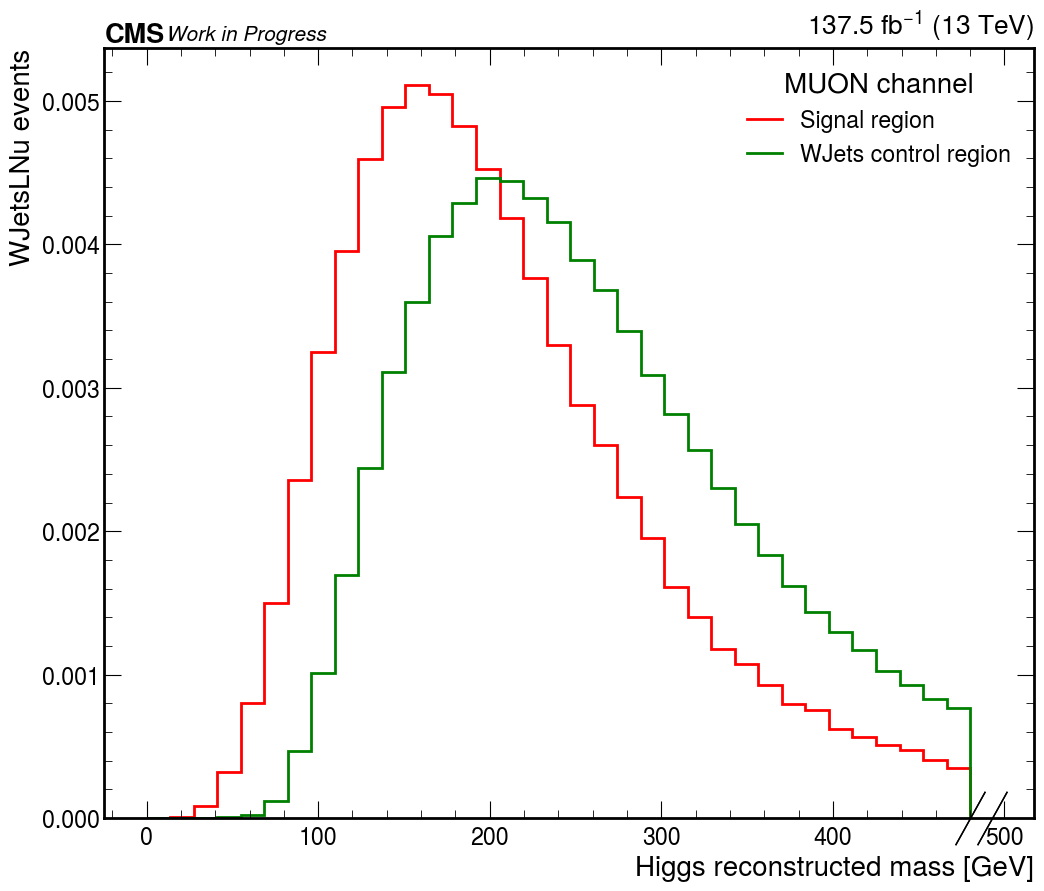

In [211]:
plt.rcParams.update({"font.size": 20})

############################## args up to you
sample = "WJetsLNu"    # optios are ["HWW", "WJetsLNu", "QCD", "TTbar"]
regions = [
#     "LepIsolation",    
#     "LepIsolationInv",
    "Signal region",
#     "QCD control region",
    "WJets control region",
#     "TTbar control region",
]       

##############################
        
var = "rec_higgs_m"
# var = "fj_ParticleNet_mass"

# make histogram
h = hist2.Hist(
    utils.axis_dict[var],
    hist2.axis.StrCategory([], name="region", growth=True),
)    

for year in years:
    for ch in channels:
    
        for region in regions:
            
            if region == "WJets control region":
                df = events_dict["LepIsolation"][year][ch][sample]
                
                bjet_cut = df["n_bjets_L"]==0
                dr_cut = df["lep_fj_dr"]>0.5
                df = df[bjet_cut & dr_cut]
                
            elif region == "Signal region":
                
                df = events_dict["Signal region"][year][ch][sample]
                
                bjet_cut = df["n_bjets_L"]!=0
                dr_cut = df["lep_fj_dr"]<0.5
                df = df[bjet_cut & dr_cut]                
            
            else:
                df = events_dict[region][year][ch][sample]

            h.fill(
                var=df[var],
                region=region,
                weight=df["event_weight"]
            )
            
            
# plot histogram
fig, ax = plt.subplots(figsize=(12, 10))

for region in regions:
    hep.histplot(
        h[{"region": region}],
        ax=ax,
        label=region,
        linewidth=2,
        density=True,
        color=color_dict[region]
    )

ax.set_ylabel(f"{sample} events");  

luminosity = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    luminosity += lum / len(channels)    

hep.cms.lumitext("%.1f " % luminosity + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
    
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

if len(channels)==1:
    ax.legend(title=f"{nice_ch[ch]} channel")
    plt.savefig(f"/Users/fmokhtar/Desktop/hww/Sep11/new_{var}_{sample}_{ch}.pdf")
else:
    ax.legend()
    plt.savefig(f"/Users/fmokhtar/Desktop/hww/Sep11/new_{var}_{sample}.pdf")    